
# Max Clique Problem



## Background

The problem is in graph theory. A clique is a subset of vertices in a graph such each pair of them is adjacent to each other.

The max clique problem is given a graph $G = (V,E)$, find the maximal clique in the graph. It is known to be in the NP-hard complexity class.


# Solving the problem with classiq

## Define the optimization problem

We encode each node

In [1]:
import networkx as nx
import numpy as np
import pyomo.environ as pyo


def define_max_clique_model(graph):
    model = pyo.ConcreteModel()

    # each x_i states if node i belongs to the cliques
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)
    x_variables = np.array(list(model.x.values()))

    # define the complement adjacency matrix as the matrix where 1 exists for each non-existing edge
    adjacency_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=0)
    complement_adjacency_matrix = (
        1
        - nx.convert_matrix.to_numpy_array(graph, nonedge=0)
        - np.identity(len(model.x))
    )

    # constraint that 2 nodes without edge in the graph cannot be chosen together
    model.clique_constraint = pyo.Constraint(
        expr=x_variables @ complement_adjacency_matrix @ x_variables == 0
    )

    # maximize the number of nodes in the chosen clique
    model.value = pyo.Objective(expr=sum(x_variables), sense=pyo.maximize)

    return model

### Initialize the model with parameters

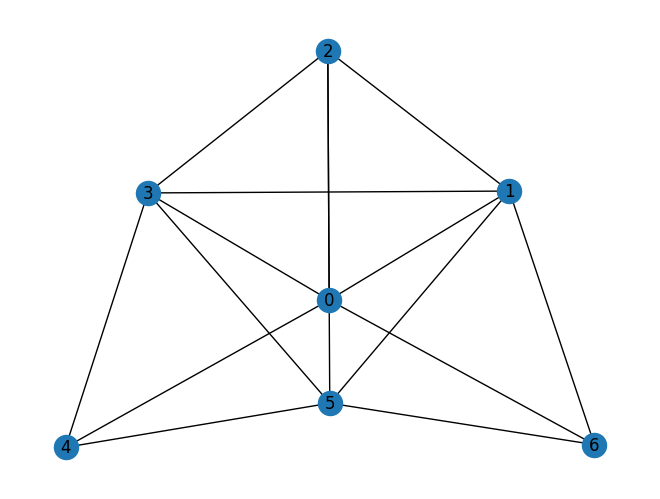

In [2]:
graph = nx.erdos_renyi_graph(7, 0.6, seed=79)
nx.draw_kamada_kawai(graph, with_labels=True)
max_clique_model = define_max_clique_model(graph)

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [3]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=20)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [4]:
optimizer_config = OptimizerConfig(max_iteration=1, alpha_cvar=1)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [5]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=max_clique_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [6]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [7]:
from classiq import write_qmod

write_qmod(qmod, "max_clique")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [8]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/88ddbcbe-e798-4683-b7be-3052b1efec1a?version=0.41.0.dev39%2B79c8fd0855


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [9]:
from classiq import execute

res = execute(qprog).result()

# Optimization Results

We can also examine the statistics of the algorithm:

In [10]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    max_clique_model, vqe_result=res[0].value, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
115,0.001,4.0,"[0, 1, 1, 1, 0, 1, 0]",1
90,0.003,4.0,"[1, 1, 1, 1, 0, 0, 0]",3
107,0.001,3.0,"[0, 1, 0, 0, 0, 1, 1]",1
111,0.001,3.0,"[1, 0, 0, 1, 1, 0, 0]",1
89,0.003,3.0,"[0, 1, 1, 0, 0, 1, 0]",3


## Resulting Clique

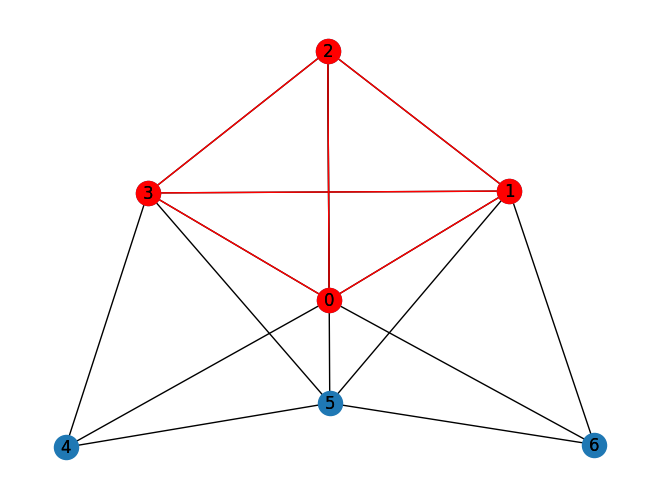

In [11]:
solution = optimization_result.solution[optimization_result.cost.idxmax()]
solution_nodes = [v for v in graph.nodes if solution[v]]
solution_edges = [
    (u, v) for u, v in graph.edges if u in solution_nodes and v in solution_nodes
]
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=solution_nodes,
    edgelist=solution_edges,
    node_color="r",
    edge_color="r",
)

And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

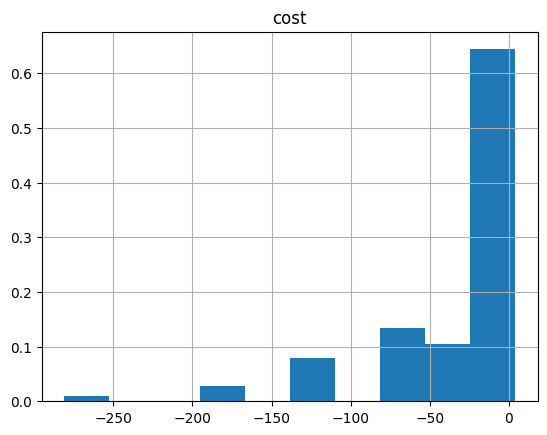

In [12]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Lastly, we can compare to the classical solution of the problem:

## Classical optimizer results

In [13]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(max_clique_model)

max_clique_model.display()

Model unknown

  Variables:
    x : Size=7, Index=x_index
        Key : Lower : Value                  : Upper : Fixed : Stale : Domain
          0 :     0 :                    1.0 :     1 : False : False : Binary
          1 :     0 :                    1.0 :     1 : False : False : Binary
          2 :     0 :                    1.0 :     1 : False : False : Binary
          3 :     0 :                    1.0 :     1 : False : False : Binary
          4 :     0 :                    0.0 :     1 : False : False : Binary
          5 :     0 : 3.9960192291414966e-08 :     1 : False : False : Binary
          6 :     0 :                    0.0 :     1 : False : False : Binary

  Objectives:
    value : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 4.0000000399601925

  Constraints:
    clique_constraint : Size=1
        Key  : Lower : Body                  : Upper
        None :   0.0 : 7.992038458282993e-08 :   0.0


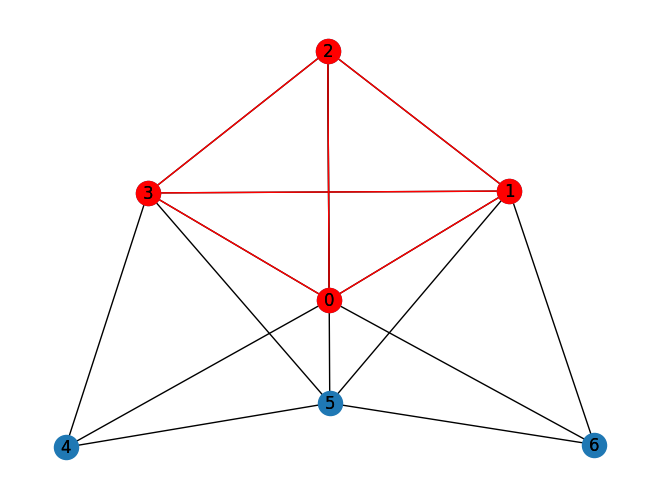

In [14]:
solution = [int(pyo.value(max_clique_model.x[i])) for i in graph.nodes]
solution_nodes = [v for v in graph.nodes if solution[v]]
solution_edges = [
    (u, v) for u, v in graph.edges if u in solution_nodes and v in solution_nodes
]
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=solution_nodes,
    edgelist=solution_edges,
    node_color="r",
    edge_color="r",
)